#Importing data and libraries

In [ ]:
# Code taken from https://pypi.org/project/gdown/
import gdown

In [ ]:
url = "https://drive.google.com/drive/folders/15LpkCSgro5H-ZzbARRVw7cT23sz3cPGC?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/project/movies_classification_updated.csv',
 '/content/project/movies_classification.csv',
 '/content/project/movies_metadata.csv',
 '/content/project/XGBoost_model.ipynb']

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [ ]:
data = pd.read_csv('/content/project/movies_classification_updated.csv')
metadata = pd.read_csv('/content/project/movies_metadata.csv')

<ipython-input-375-238be40e0e7d>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/project/movies_metadata.csv')


In [ ]:
data.isnull().sum()

Unnamed: 0                 0
belongs_to_collection      0
budget                     0
popularity                 0
revenue                    0
runtime                  251
title                      0
vote_average               0
vote_count                 0
Animation                  0
Comedy                     0
Family                     0
Adventure                  0
Fantasy                    0
Romance                    0
Drama                      0
Action                     0
Crime                      0
Thriller                   0
Horror                     0
History                    0
Science Fiction            0
Mystery                    0
War                        0
Foreign                    0
Music                      0
Documentary                0
Western                    0
TV Movie                   0
english                    0
release_year              78
release_month             78
dtype: int64

In [ ]:
#dropping data with null values since theres so few:

#null runtimes
null_runtimes = data[data['runtime'].isnull()].index.tolist()
data = data.drop(null_runtimes)

#null release info
null_dates = data[data['release_year'].isnull()].index.tolist()
data = data.drop(null_dates)

In [ ]:
data.isnull().sum()

Unnamed: 0               0
belongs_to_collection    0
budget                   0
popularity               0
revenue                  0
runtime                  0
title                    0
vote_average             0
vote_count               0
Animation                0
Comedy                   0
Family                   0
Adventure                0
Fantasy                  0
Romance                  0
Drama                    0
Action                   0
Crime                    0
Thriller                 0
Horror                   0
History                  0
Science Fiction          0
Mystery                  0
War                      0
Foreign                  0
Music                    0
Documentary              0
Western                  0
TV Movie                 0
english                  0
release_year             0
release_month            0
dtype: int64

#Getting train test split

In [ ]:
y=data.revenue
X= data.drop(columns=['Unnamed: 0', 'revenue', 'popularity', 'title'])

In [ ]:
#splitting into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
X_test=X_test.drop(columns=['vote_average', 'vote_count'])
X_train=X_train.drop(columns=['vote_average', 'vote_count'])

####Is data proportonal?

In [ ]:
#Proportion of 0s and 1s in the complete data
y.value_counts()/y.shape

0.0    0.834683
1.0    0.165317
Name: revenue, dtype: float64

In [ ]:
#Proportion of 0s and 1s in train data
y_train.value_counts()/y_train.shape

0.0    0.834741
1.0    0.165259
Name: revenue, dtype: float64

In [ ]:
#Proportion of 0s and 1s in test data
y_test.value_counts()/y_test.shape

0.0    0.834452
1.0    0.165548
Name: revenue, dtype: float64

#Fitting naive model

In [ ]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'recall', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

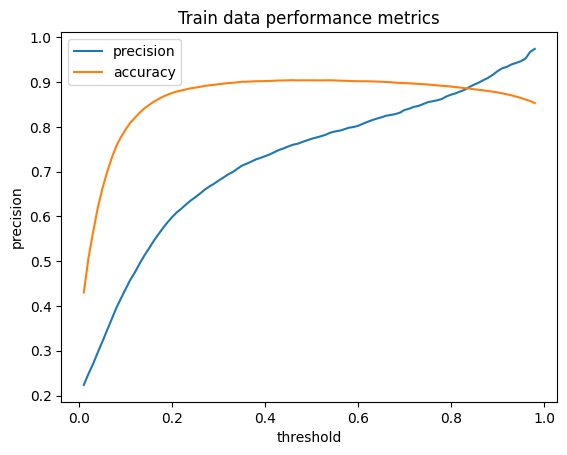

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.8
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.7,.85,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

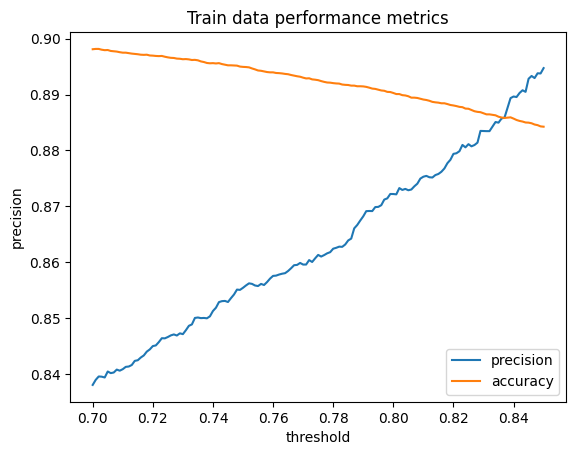

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
#finding optimal decision threshold
performance_iter[~performance_iter['accuracy'].between(0.78, 0.84)].sort_values('precision', ascending=False)

,accuracy,precision,threshold
150,0.884243,0.894737,0.85
148,0.884523,0.893805,0.848
149,0.884299,0.893778,0.849
146,0.884858,0.893327,0.846
147,0.884635,0.892952,0.847
...,...,...,...
2,0.898171,0.839521,0.702
3,0.898031,0.839484,0.703
4,0.897947,0.839339,0.704
1,0.898171,0.838912,0.701


In [ ]:
model = xgb.XGBClassifier().fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.85

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.818):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics (with decision threshold of 0.818):
Accuracy:  88.5234899328859
Precision:  0.8982456140350877


#Finding parameter grids for primary Grid Search

>10 0.907 (0.004)
>50 0.907 (0.004)
>100 0.906 (0.004)
>500 0.899 (0.004)
>1000 0.895 (0.004)
>5000 0.885 (0.003)


Text(0.5, 0, 'Number of trees')

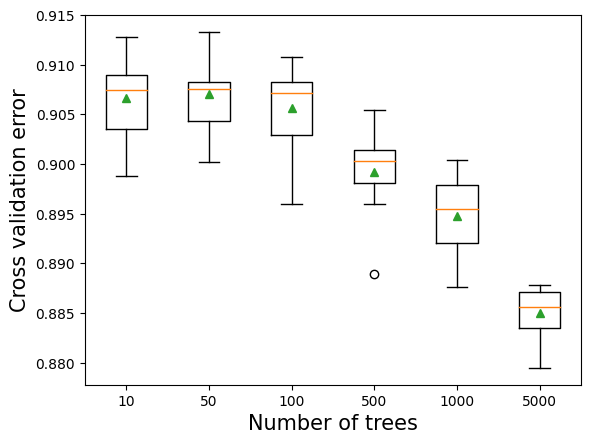

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.902 (0.005)
>2 0.906 (0.005)
>3 0.906 (0.004)
>4 0.906 (0.004)
>5 0.907 (0.004)
>6 0.906 (0.004)
>7 0.903 (0.004)
>8 0.903 (0.004)
>9 0.902 (0.004)
>10 0.900 (0.004)
>11 0.899 (0.003)
>12 0.897 (0.005)
>13 0.898 (0.004)
>14 0.897 (0.004)
>15 0.898 (0.004)
>16 0.896 (0.003)
>17 0.896 (0.004)
>18 0.896 (0.004)
>19 0.895 (0.004)
>20 0.895 (0.003)


Text(0.5, 0, 'Depth of each tree')

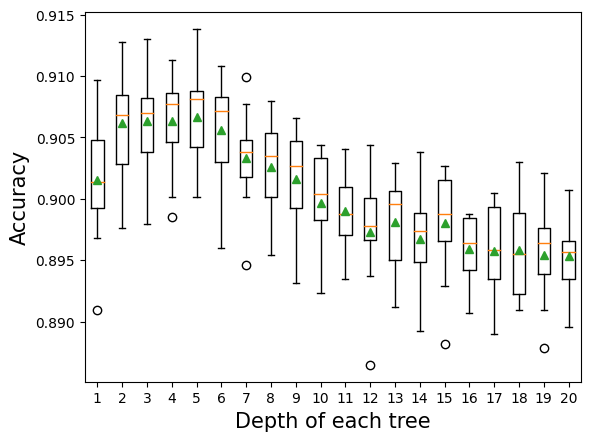

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBClassifier(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1 0.907 (0.005)
>0.2 0.907 (0.006)
>0.3 0.906 (0.005)
>0.4 0.904 (0.004)
>0.5 0.901 (0.005)
>0.6 0.900 (0.005)
>0.7 0.899 (0.004)
>0.8 0.896 (0.006)
>0.9 0.895 (0.005)
>1.0 0.892 (0.003)
>1.1 0.890 (0.004)
>1.2 0.889 (0.003)
>1.3 0.886 (0.005)
>1.4 0.884 (0.004)
>1.5 0.883 (0.003)
>1.6 0.883 (0.005)
>1.7 0.878 (0.004)
>1.8 0.875 (0.008)
>1.9 0.860 (0.011)
>2.0 0.849 (0.025)


Text(0.5, 0, 'Learning rate')

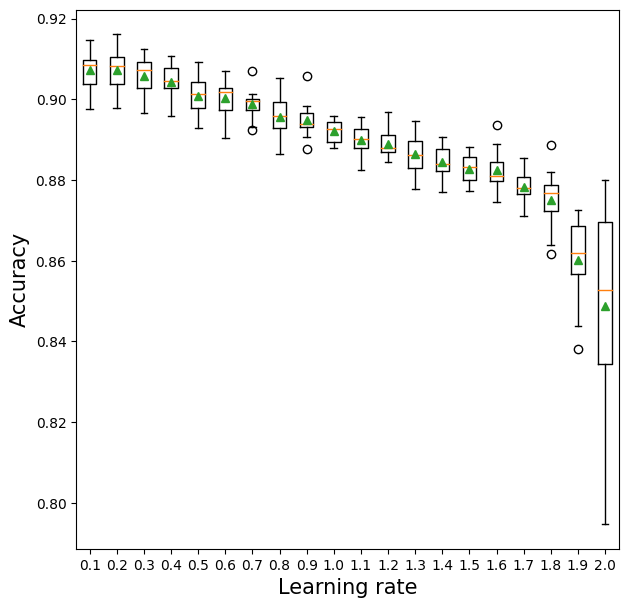

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = xgb.XGBClassifier(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0000 0.903 (0.005)
>0.5000 0.904 (0.005)
>1.0000 0.906 (0.005)
>1.5000 0.906 (0.005)
>2.0000 0.905 (0.005)
>10.0000 0.906 (0.005)
>100.0000 0.907 (0.004)


Text(0.5, 0, 'reg lambda')

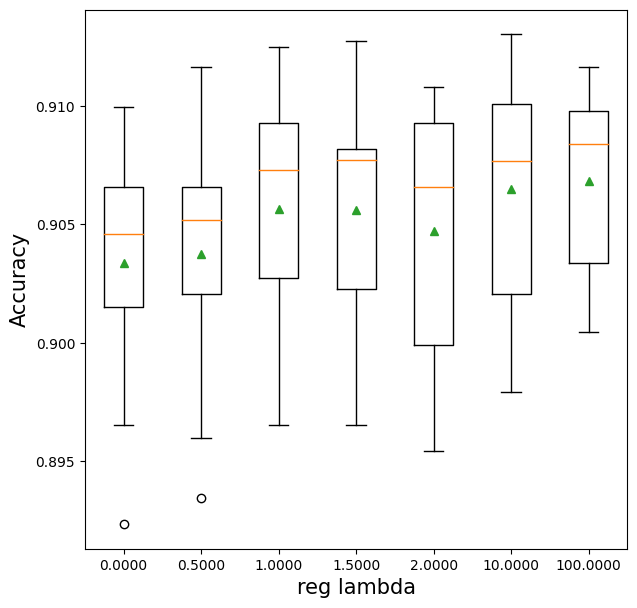

In [ ]:
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('reg lambda',fontsize=15)

>0.0000 0.906 (0.005)
>10.0000 0.906 (0.005)
>100.0000 0.904 (0.004)
>1000.0000 0.898 (0.005)
>10000.0000 0.835 (0.003)
>100000.0000 0.835 (0.003)
>1000000.0000 0.835 (0.003)
>10000000.0000 0.835 (0.003)
>100000000.0000 0.835 (0.003)
>1000000000.0000 0.835 (0.003)


Text(0.5, 0, 'Gamma')

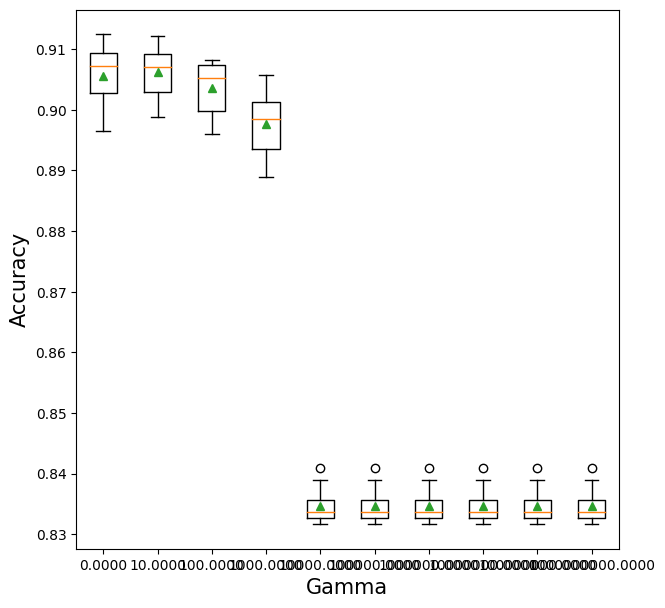

In [ ]:
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Gamma',fontsize=15)

In [ ]:
##determining a good scale_pos_weight
y.value_counts()

scale_pos_weight = np.sqrt((37619)/(7395)) 
scale_pos_weight

2.2554569091051797

In [ ]:
#randomizedsearch
start_time = time.time()
param_grid = {'n_estimators':[10,100,500],
                'max_depth': [2,4,6,8],
              'learning_rate': [0.01,0.1, 0.3],
               'gamma':[0,10,100,1000],
               'reg_lambda':[0,10,100],
                'scale_pos_weight':[1.25,1.75,2.25]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_distributions = param_grid,
                             n_iter = 200,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'scale_pos_weight': 1.25, 'reg_lambda': 100, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0} 0.9068128681178177
Time taken =  7.520998700459798  minutes


In [ ]:
start_time = time.time()
param_grid = {'n_estimators':[50, 100, 250],
                'max_depth': [5,6,7],
              'learning_rate': [.2, 0.3,.4],
               'gamma':[0,1],
               'reg_lambda':[10, 100, 1000],
                'scale_pos_weight':[1, 1.25,1.5]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 100, 'scale_pos_weight': 1} 0.9073442388652329
Time taken =  15.627576092878977  minutes


#Testing parameters from primary grid search

In [ ]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(gamma= 0, learning_rate=0.3, max_depth=6, n_estimators= 100, reg_lambda=100, scale_pos_weight=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

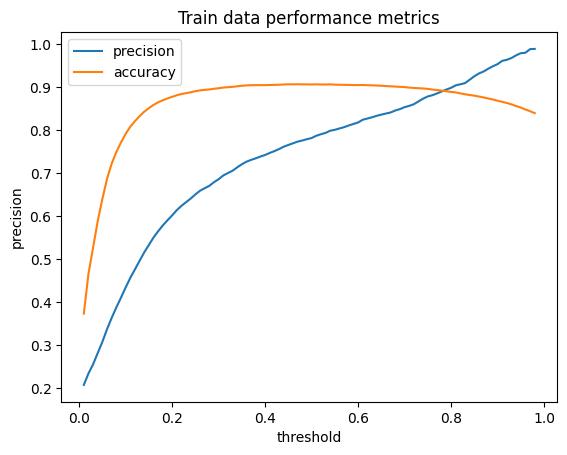

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5-.6
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.8,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

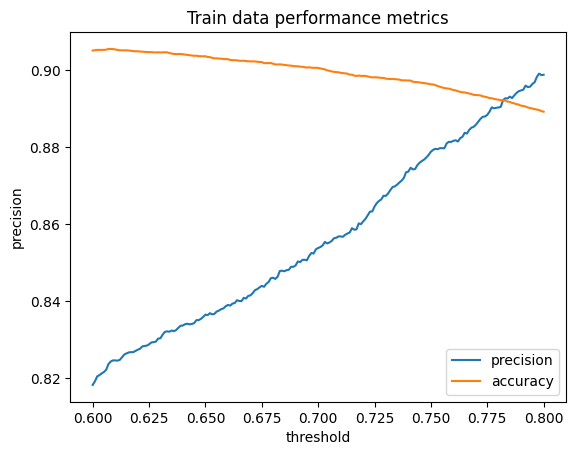

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
performance_iter.loc[performance_iter['accuracy']>.8].sort_values('precision',ascending=False)
#performance_iter[~performance_iter['accuracy'].between(0.1, 0.78)].sort_values('precision', ascending=False)

,accuracy,precision,threshold
198,0.889557,0.899023,0.798
200,0.889137,0.898729,0.8
199,0.889305,0.898651,0.799
197,0.889641,0.898174,0.797
196,0.889781,0.896774,0.796
...,...,...,...
4,0.905163,0.821173,0.604
3,0.905191,0.820728,0.603
2,0.905191,0.820402,0.602
1,0.905107,0.819127,0.601


In [ ]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.3, max_depth=6, n_estimators= 100, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.798

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.533):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics (with decision threshold of 0.533):
Accuracy:  89.17225950782998
Precision:  0.9012539184952978


###Naive model metrics:
Test data performance metrics (with decision threshold of 0.818):<br>
Accuracy:  88.5234899328859<br>
Precision:  0.8982456140350877

###1st tuning model metrics:
Test data performance metrics (with decision threshold of 0.533):<br>
Accuracy:  89.17225950782998<br>
Precision:  0.9012539184952978

#Further tuning

In [ ]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 100, reg_lambda=100, scale_pos_weight=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

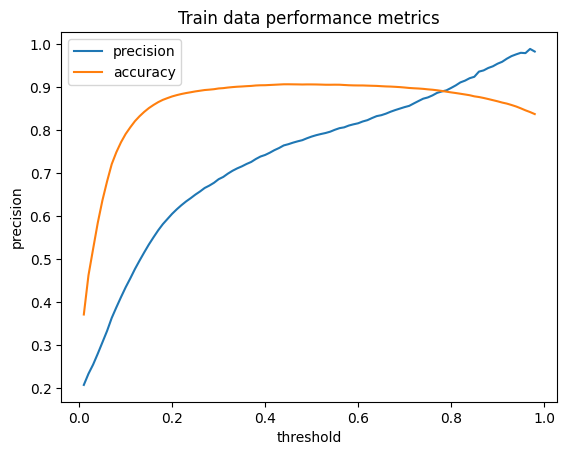

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5-.6
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.8,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

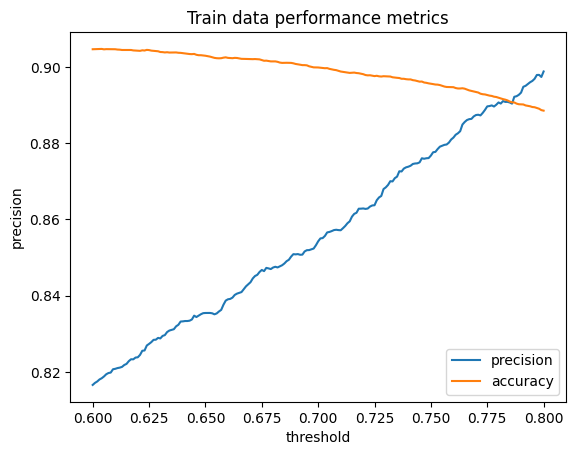

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
performance_iter.loc[performance_iter['accuracy']>.8].sort_values('precision',ascending=False)
#performance_iter[~performance_iter['accuracy'].between(0.1, 0.78)].sort_values('precision', ascending=False)

,accuracy,precision,threshold
200,0.888522,0.898797,0.8
198,0.889026,0.897909,0.798
197,0.889221,0.897876,0.797
199,0.888662,0.897362,0.799
196,0.889417,0.896874,0.796
...,...,...,...
4,0.904715,0.818321,0.604
3,0.904715,0.817997,0.603
2,0.904687,0.817466,0.602
1,0.904659,0.817098,0.601


In [ ]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 100, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.8

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.8):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics (with decision threshold of 0.8):
Accuracy:  89.31767337807607
Precision:  0.9107981220657277


In [ ]:
start_time = time.time()
param_grid = {'n_estimators':[75, 90, 100, 110, 150],
                'max_depth': [6],
              'learning_rate': [0.25],
               'gamma':[0],
               'reg_lambda':[100],
               'scale_pos_weight':[1]}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'gamma': 0, 'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 150, 'reg_lambda': 100, 'scale_pos_weight': 1} 0.907176441898741
Time taken =  0.28126120964686074  minutes


In [ ]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 100, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [ ]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

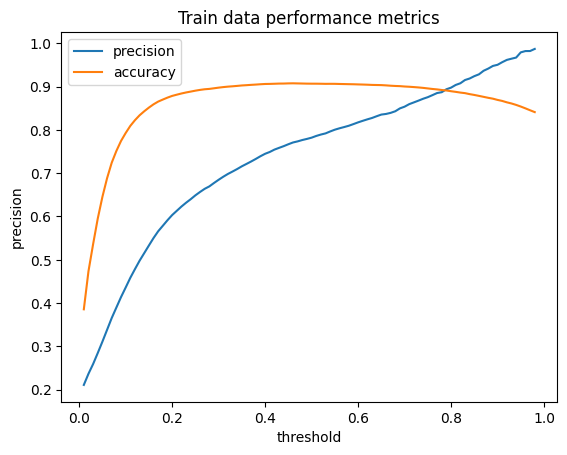

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.85,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

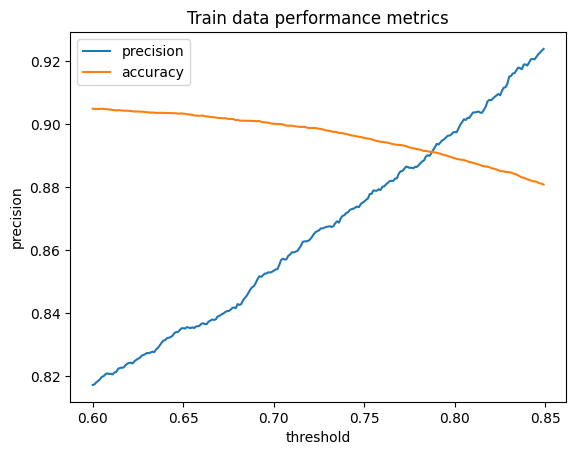

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.88].sort_values('precision', ascending=False)

,accuracy,precision,threshold
249,0.880775,0.92379,0.849
248,0.881027,0.923274,0.848
247,0.881167,0.922607,0.847
246,0.881391,0.922065,0.846
245,0.881698,0.921224,0.845
...,...,...,...
4,0.904743,0.819016,0.604
3,0.904743,0.818529,0.603
2,0.904771,0.818089,0.602
1,0.904771,0.817444,0.601


In [ ]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.849

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics (with decision threshold of 0.8):
Accuracy:  88.27740492170022
Precision:  0.9251968503937008


##Naive model metrics:
Test data performance metrics (with decision threshold of 0.85):<br>
Accuracy: 88.5234899328859<br>
Precision: 0.8982456140350877

##1st tuning model metrics:
Test data performance metrics (with decision threshold of 0.798):<br>
Accuracy: 89.17225950782998<br>
Precision: 0.9012539184952978

##1st tuning model with some manual adjustments:
Test data performance metrics (with decision threshold of 0.8):<br>
Accuracy:  89.31767337807607<br>
Precision:  0.9107981220657277

##2nd tuning model:
Test data performance metrics (with decision threshold of 0.849):<br>
Accuracy:  88.27740492170022<br>
Precision:  0.9251968503937008